# Pair Density ERI Analysis

Compare Electron Repulsion Integrals (ERIs) calculated with pair density with ERIs calculated by explicit sum implemented in the Rust and CUDA code. Also we analyse the momentum grid and $\psi_i(p)$ represented as a 3D array

In [101]:
import os
import xmltodict
from wfc import Wfc
import calc_matrix_elements
from eri_pair_densities import *
import matplotlib.pyplot as plt

Load data

In [102]:

dat_file = os.path.join("qe_files", "out_Mg", "Mg.save", "wfc1.dat")
xml_file = os.path.join("qe_files", "out_Mg", "Mg.save", "data-file-schema.xml")

dat_file = os.path.join("qe_files", "out_H2", "H2.save", "wfc1.dat")
xml_file = os.path.join("qe_files", "out_H2", "H2.save", "data-file-schema.xml")

# Choose Kohn-Sham orbitals
orbitals_indices = [0, 1]

wfc1_ncpp = Wfc.from_file(dat_file, xml_file)

with open(xml_file, "r", encoding="utf-8") as file:
    xml_dict = xmltodict.parse(file.read())
reference_energy = xml_dict["qes:espresso"]["output"]["total_energy"]["etot"]

overlaps_ncpp = wfc1_ncpp.get_overlaps()

p = wfc1_ncpp.k_plus_G  # shape (#waves, 3)
c_ip = wfc1_ncpp.evc  # shape (#bands, #waves)

Calculate ERIs via pair densities

In [103]:
# For application we need to rescale ERIs by the cell volume
# Commented out for comparing with Rust and CUDA results
eri = eri_gamma(p=p, c_ip=c_ip)  # / wfc1_ncpp.cell_volume

rho_ij_p.shape: (4, 4, 15, 15, 15)


Check symmetries of calculated ERIs

In [104]:
# Check symmetries of ERIs
sym = calc_matrix_elements.check_symmetry_two_body_matrix(eri)
print(
    f"swap symmetry {'fulfilled' if sym[0] else 'not fulfilled'}, "
    f"hermiticity {'fulfilled' if sym[1] else 'not fulfilled'}, hermiticity+swap {'fulfilled' if sym[2] else 'not fulfilled'}!"
)

swap symmetry fulfilled, hermiticity fulfilled, hermiticity+swap fulfilled!


Plot momentum grid used in QuantumEspresso projected on the x-y-plane

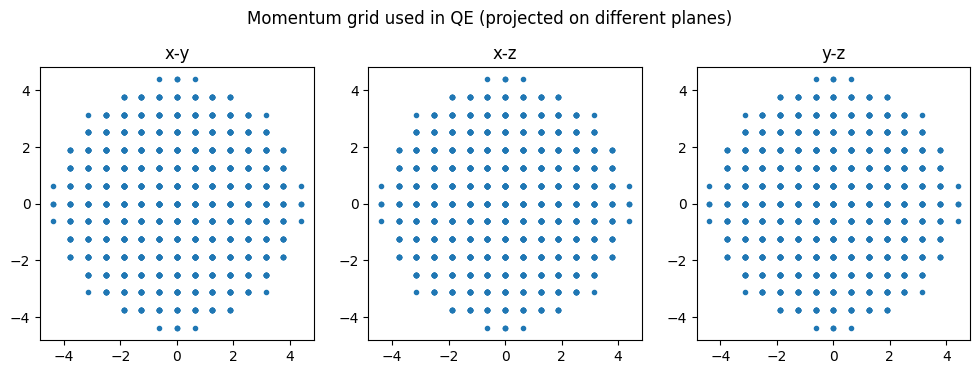

In [105]:
# grid_min_x = p[:, 0].min()
# grid_max_x = p[:, 0].max()
# grid_min_y = p[:, 1].min()
# grid_max_y = p[:, 1].max()
# grid_min_z = p[:, 2].min()
# grid_max_z = p[:, 2].max()

# Plot momentum grid used in QuantumEspresso (projected on x-y-plane)
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.suptitle("Momentum grid used in QE (projected on different planes)")
ax[0].plot(p[:, 0], p[:, 1], ".")
# ax[0].plot(grid_max_x, 0.0, "X")
# ax[0].plot(grid_max_y, 0.0, "X")
# ax[0].plot(grid_max_z, 0.0, "X")
# ax[0].set_xlim(9, 10)
ax[0].set_title("x-y")
ax[1].plot(p[:, 0], p[:, 2], ".")
ax[1].set_title("x-z")
ax[2].plot(p[:, 1], p[:, 2], ".")
ax[2].set_title("y-z")
# plt.legend()
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[2].set_aspect("equal")

In [106]:
# differences = p[:, np.newaxis] - p
# print(differences.shape)
# norms=np.linalg.norm(differences, ord=2, axis=2)
# np.unique(norms)

print(np.linalg.norm(p[0] - p[1], ord=2))
print("p diffs")
print(p[0] - p[1])
print(p[1] - p[2])
print(p[0] - p[2])
print(p[0] - p[3])
print(p[0] - p[4])

print("p")
print(p[:5])
print()

print("b:")
print(wfc1_ncpp.b)
print("dat/hdf5:")
print(wfc1_ncpp.b1)
print(wfc1_ncpp.b2)
print(wfc1_ncpp.b3)
# print("xml:")
# print(wfc1_ncpp.b1_xml)
# print(wfc1_ncpp.b2_xml)
# print(wfc1_ncpp.b3_xml)
# print(np.linalg.norm(wfc1_ncpp.b, ord=2, axis=1))

print()
print(wfc1_ncpp.mill[:5])

print("einstein sum")
np.einsum("ij,jk->ik", wfc1_ncpp.mill, wfc1_ncpp.b)[:5]

# print(wfc1_ncpp.a1)
# print(wfc1_ncpp.a2)
# print(wfc1_ncpp.a3)

0.6283185307179586
p diffs
[ 0.          0.         -0.62831853]
[ 0.         -0.62831853  0.62831853]
[ 0.         -0.62831853  0.        ]
[-0.62831853  0.          0.        ]
[ 0.         -0.62831853  0.62831853]
p
[[ 0.          0.          0.        ]
 [ 0.          0.          0.62831853]
 [ 0.          0.62831853  0.        ]
 [ 0.62831853  0.          0.        ]
 [ 0.          0.62831853 -0.62831853]]

b:
[[0.62831853 0.         0.        ]
 [0.         0.62831853 0.        ]
 [0.         0.         0.62831853]]
dat/hdf5:
[0.62831853 0.         0.        ]
[0.         0.62831853 0.        ]
[0.         0.         0.62831853]

[[ 0  0  0]
 [ 0  0  1]
 [ 0  1  0]
 [ 1  0  0]
 [ 0  1 -1]]
einstein sum


array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.62831853],
       [ 0.        ,  0.62831853,  0.        ],
       [ 0.62831853,  0.        ,  0.        ],
       [ 0.        ,  0.62831853, -0.62831853]])

Create 3D array of $\psi_i(p)$ as done in `eri_gamma` function. Also compute shifted $\psi_i(p)$ used as input for numpy FFT methods

In [107]:
# Create 3d array containing momentum vectors on a grid extend to a rectangular grid
# Same as in eri_gamma function
grid_min_x = p[:, 0].min()
grid_max_x = p[:, 0].max()
grid_min_y = p[:, 1].min()
grid_max_y = p[:, 1].max()
grid_min_z = p[:, 2].min()
grid_max_z = p[:, 2].max()
# assume equally spaced grid
# grid_spacing = np.linalg.norm(p[0] - p[1], ord=2)
# grid_spacing = wfc1_ncpp.b1, wfc1_ncpp.b2, wfc1_ncpp.b3
grid_spacing_x = np.linalg.norm(wfc1_ncpp.b1, ord=2)
grid_spacing_y = np.linalg.norm(wfc1_ncpp.b2, ord=2)
grid_spacing_z = np.linalg.norm(wfc1_ncpp.b3, ord=2)

print(f"grid_min_max_x: {grid_min_x}|{grid_max_x}")
print(f"grid_min_max_y: {grid_min_y}|{grid_max_y}")
print(f"grid_min_max_z: {grid_min_z}|{grid_max_z}")

print(wfc1_ncpp.mill.max(axis=0) - wfc1_ncpp.mill.min(axis=0) + 1)

c_ip_array = np.zeros(
    (
        c_ip.shape[0],
        *(wfc1_ncpp.mill.max(axis=0) - wfc1_ncpp.mill.min(axis=0) + 1)
        # int((grid_max_x - grid_min_x) / grid_spacing_x) + 1,
        # int((grid_max_y - grid_min_y) / grid_spacing_y) + 1,
        # int((grid_max_z - grid_min_z) / grid_spacing_z) + 1,
    ),
    dtype=c_ip.dtype,
)

print(f"c_ip_array shape: {c_ip_array.shape}")
print(f"p shape: {p.shape}")

for idx, mill_idx in enumerate(wfc1_ncpp.mill):
    x, y, z = mill_idx
    max_min = wfc1_ncpp.mill.max(axis=0) - wfc1_ncpp.mill.min(axis=0)
    i, j, k = (
        x + max_min[0] // 2,
        y + max_min[1] // 2,
        z + max_min[2] // 2,
    )
    # print(x,y,z, " | ", i,j,k)
    c_ip_array[:, i, j, k] = c_ip[:, idx]

# for idx, coords in enumerate(p):
#     x, y, z = coords
#     i, j, k = (
#         int((x - grid_min_x) / grid_spacing_x),
#         int((y - grid_min_y) / grid_spacing_y),
#         int((z - grid_min_z) / grid_spacing_z),
#     )
#     c_ip_array[:, i, j, k] = c_ip[:, idx]

p_norm_array = np.zeros(c_ip_array.shape[1:])
for i in range(p_norm_array.shape[0]):
    x = (i * grid_spacing_x) + grid_min_x
    for j in range(p_norm_array.shape[1]):
        y = (j * grid_spacing_y) + grid_min_y
        for k in range(p_norm_array.shape[2]):
            z = (k * grid_spacing_z) + grid_min_z
            p_norm_array[i, j, k] = x**2 + y**2 + z**2

max_min = wfc1_ncpp.mill.max(axis=0) - wfc1_ncpp.mill.min(axis=0)
for i in range(p_norm_array.shape[0]):
    for j in range(p_norm_array.shape[1]):
        for k in range(p_norm_array.shape[2]):
            x = i - max_min[0] // 2
            y = j - max_min[1] // 2
            z = k - max_min[2] // 2
            p_norm_array[i, j, k] = np.linalg.norm(wfc1_ncpp.b1 * x + wfc1_ncpp.b2 * y + wfc1_ncpp.b3 * z, ord=2)**2

# for idx, mill_idx in enumerate(wfc1_ncpp.mill):
#     x, y, z = mill_idx
#     max_min = wfc1_ncpp.mill.max(axis=0) - wfc1_ncpp.mill.min(axis=0)
#     i, j, k = (
#         x + max_min[0] // 2,
#         y + max_min[1] // 2,
#         z + max_min[2] // 2,
#     )
#     p_norm_array[i, j, k] = wfc1_ncpp.k_plus_G_norm[idx]

c_ip_array_shifted = np.fft.ifftshift(c_ip_array, axes=(1, 2, 3))

grid_min_max_x: -4.39822971502571|4.39822971502571
grid_min_max_y: -4.39822971502571|4.39822971502571
grid_min_max_z: -4.39822971502571|4.39822971502571
[15 15 15]
c_ip_array shape: (4, 15, 15, 15)
p shape: (1503, 3)


In [108]:
print(wfc1_ncpp.mill.max(axis=0))
print(wfc1_ncpp.mill.min(axis=0))

print(grid_max_x)
print(grid_min_x)
print((grid_max_x - grid_min_x))

print("b:")
print(wfc1_ncpp.b)
print("dat/hdf5:")
print(wfc1_ncpp.b1)
print(wfc1_ncpp.b2)
print(wfc1_ncpp.b3)

print()
print((grid_max_x - grid_min_x) / np.linalg.norm(wfc1_ncpp.b1, ord=2))
print((grid_max_y - grid_min_y) / np.linalg.norm(wfc1_ncpp.b2, ord=2))
print((grid_max_z - grid_min_z) / np.linalg.norm(wfc1_ncpp.b3, ord=2))

[7 7 7]
[-7 -7 -7]
4.39822971502571
-4.39822971502571
8.79645943005142
b:
[[0.62831853 0.         0.        ]
 [0.         0.62831853 0.        ]
 [0.         0.         0.62831853]]
dat/hdf5:
[0.62831853 0.         0.        ]
[0.         0.62831853 0.        ]
[0.         0.         0.62831853]

14.0
14.0
14.0


Plot norm of momenta, unshifted and shifted $\psi_i(p)$

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3906860/2110635720.py:7: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle("$\psi_i(p)$ and momentum grid")
/tmp/ipykernel_3906860/2110635720.py:8: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_title("$\psi_i(p)$ projected on x-y-plane at z=0")


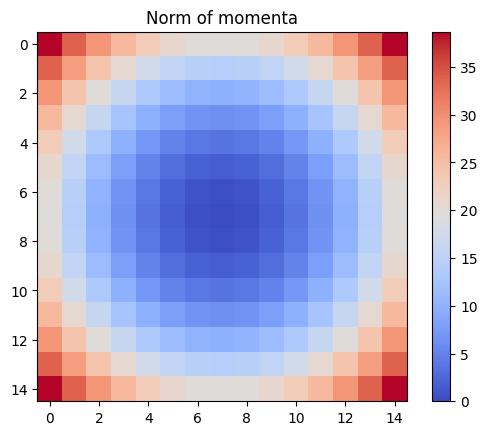

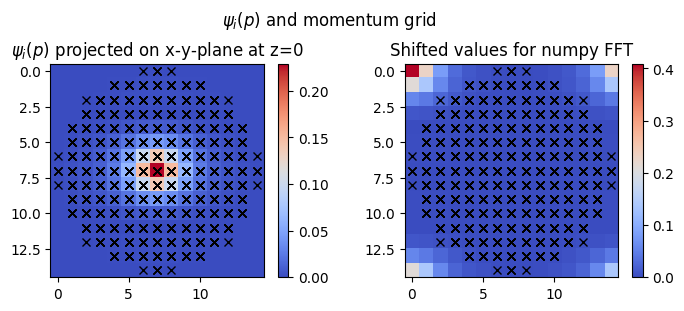

In [109]:
plt.figure()
plt.title("Norm of momenta")
plt.imshow(p_norm_array[:, :, 7], cmap="coolwarm")
plt.colorbar()

fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
fig.suptitle("$\psi_i(p)$ and momentum grid")
ax[0].set_title("$\psi_i(p)$ projected on x-y-plane at z=0")
z_0_idx = c_ip_array.shape[2] // 2 - 1
im = ax[0].imshow(
    np.abs(c_ip_array[0, :, :, z_0_idx]), cmap="coolwarm"
)
ax[0].plot(
    (p[:, 0] - grid_min_x) / grid_spacing_x,
    (p[:, 1] - grid_min_y) / grid_spacing_y,
    "x",
    c="black",
)
ax[1].set_title("Shifted values for numpy FFT")
im2 = ax[1].imshow(
    np.abs(c_ip_array_shifted[0, :, :, 0]), cmap="coolwarm"
)  # After shift center frequency is at index 0
ax[1].plot(
    (p[:, 0] - grid_min_x) / grid_spacing_x,
    (p[:, 1] - grid_min_y) / grid_spacing_y,
    "x",
    c="black",
)
fig.colorbar(im)
fig.colorbar(im2)
